In [1]:
from torchviz import make_dot
import squidpy as sq
import scanpy as sc
import matplotlib.pyplot as plt
from GraphST.graphst import GraphST
from GraphST.utils import clustering
import networkx as nx
import torch
import numpy as np
import pandas as pd
import time
from torch_geometric.explain import Explainer, GNNExplainer

from GraphST.graphst import Encoder, ExplainableEncoder, BaseEncoder, GraphStEncoder
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.utils import dense_to_sparse

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
device

/home/amintehrani/graphst-test/venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/amintehrani/graphst-test/venv/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/amintehrani/.pyenv/versions/3.12.8/envs/torchgeo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

In [2]:
adata = sq.read.visium("dataset/V1_Human_Lymph_Node")
adata

/home/amintehrani/graphst-test/venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/amintehrani/graphst-test/venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4035 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
adata.obs.index.unique()

Index(['AAACAAGTATCTCCCA-1', 'AAACAATCTACTAGCA-1', 'AAACACCAATAACTGC-1',
       'AAACAGAGCGACTCCT-1', 'AAACAGCTTTCAGAAG-1', 'AAACAGGGTCTATATT-1',
       'AAACAGTGTTCCTGGG-1', 'AAACATTTCCCGGATT-1', 'AAACCCGAACGAAATC-1',
       'AAACCGGGTAGGTACC-1',
       ...
       'TTGTGTTTCCCGAAAG-1', 'TTGTTAGCAAATTCGA-1', 'TTGTTCAGTGTGCTAC-1',
       'TTGTTGGCAATGACTG-1', 'TTGTTGTGTGTCAAGA-1', 'TTGTTTCACATCCAGG-1',
       'TTGTTTCATTAGTCTA-1', 'TTGTTTCCATACAACT-1', 'TTGTTTGTATTACACG-1',
       'TTGTTTGTGTAAATTC-1'],
      dtype='object', length=4035)

In [4]:
graphclust = pd.read_csv("dataset/V1_Human_Lymph_Node/analysis/clustering/graphclust/clusters.csv")
graphclust.set_index("Barcode", inplace=True)
adata.obs['graphclust'] = graphclust['Cluster'] - 1

In [5]:
gst = GraphST(adata, device=device)

/home/amintehrani/graphst-test/venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [13]:
from GraphST.model import AvgReadout

ar = AvgReadout()
ar.forward(torch.rand(10, 5), torch.rand((10, 10)))

tensor([[0.5352, 0.4965, 0.3917, 0.4581, 0.3223],
        [0.5560, 0.5341, 0.3775, 0.4378, 0.2672],
        [0.5164, 0.4713, 0.4435, 0.4343, 0.3549],
        [0.5209, 0.4168, 0.5016, 0.3888, 0.3901],
        [0.5069, 0.5441, 0.4102, 0.4208, 0.3187],
        [0.5505, 0.4434, 0.4523, 0.4265, 0.3373],
        [0.4753, 0.5043, 0.4097, 0.4761, 0.3538],
        [0.5577, 0.5045, 0.3850, 0.4288, 0.3199],
        [0.5325, 0.3617, 0.4597, 0.4806, 0.3784],
        [0.4981, 0.4853, 0.5362, 0.3600, 0.3151]])

In [ ]:
gadata = gst.train()

Begin to train ST data...


100%|██████████| 600/600 [06:13<00:00,  1.61it/s]


Optimization finished for ST data!


In [ ]:
clustering(gadata, method="leiden")

In [9]:
G = nx.from_numpy_array(gst.adj.numpy())

In [10]:
hires_scale = adata.uns['spatial']['V1_Human_Lymph_Node']['scalefactors']['tissue_hires_scalef']
coords_hires = adata.obsm['spatial'] * hires_scale
pos = coords_hires

In [11]:
ax = plt.subplot(1, 2, 1)
ax.imshow(adata.uns['spatial']['V1_Human_Lymph_Node']['images']['hires'])
ax.invert_yaxis()
ax.axis('off')
nx.draw(G, pos=pos, node_size=3, node_color=gadata.obs['graphclust'].astype(int).tolist(), edge_color='gray', with_labels=False, ax=ax)
ax.set_title("True Clustering")

ax = plt.subplot(1, 2, 2)
ax.imshow(adata.uns['spatial']['V1_Human_Lymph_Node']['images']['hires'])
ax.invert_yaxis()
ax.axis('off')
nx.draw(G, pos=pos, node_size=3, node_color=gadata.obs['leiden'].astype(int).tolist(), edge_color='gray', with_labels=False, ax=ax)
ax.set_title("GraphST using Leiden clustering")


plt.show()

KeyError: 'leiden'

Error in callback <function flush_figures at 0x7bae37418400> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [33]:
# save the gst.model weights
torch.save(gst.model.base_encoder.state_dict(), "base_encoder_weights.pth")

In [12]:
# base_encoder = gst.model.base_encoder
base_encoder = BaseEncoder(gst.dim_input, gst.dim_output, gst.graph_neigh, is_sparse=False)
base_encoder.load_state_dict(torch.load("base_encoder_weights.pth", weights_only=True), )
base_encoder = base_encoder.to(device)

xmodel = ExplainableEncoder(base_encoder).to(device)

In [13]:
import multiprocessing as mp

# Move this outside to make it picklable
def explain_single_node(args):
    xmodel, feat, adj, index, epochs = args
    edge_index, _ = dense_to_sparse(adj)
    explainer = Explainer(
        model=xmodel,
        algorithm=GNNExplainer(epochs=epochs),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type=None,
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs',
        ),
    )
    print(f"Explaining node {index} at {time.ctime()}")
    return explainer(feat, edge_index, index=index)

# Main explain function
def explain(xmodel, feat, adj, node_ids: list, epochs=100, parallel_num_proc=mp.cpu_count()):
    if parallel_num_proc is None or parallel_num_proc <= 1:
        # Sequential
        for node_index in node_ids:
            yield explain_single_node((xmodel, feat, adj, node_index, epochs))
    else:
        args_list = [(xmodel, feat, adj, node_index, epochs) for node_index in node_ids]
        with mp.get_context("spawn").Pool(processes=parallel_num_proc) as pool:
            for explanation in pool.imap(explain_single_node, args_list):
                yield explanation


In [14]:
import importlib
import explain_module
importlib.reload(explain_module)

from explain_module import explain, explain_single_node

In [ ]:
# cluster_num = 0
# node_barcodes = adata.obs[adata.obs['graphclust'] == cluster_num].index.tolist()
# # convert node_ids (barcodes) to numerical indices
# node_ids = [adata.obs.index.get_loc(barcode) for barcode in node_barcodes]
# explanations = list(explain(base_encoder, gst.features, gst.adj, node_ids[:10]))

In [15]:
def calc_cluster_explanations(cluster_num, limit=10, epochs=100, parallel_num_proc=None):
    node_barcodes = adata.obs[adata.obs['graphclust'] == cluster_num].index.tolist()
    # convert node_ids (barcodes) to numerical indices
    node_ids = [adata.obs.index.get_loc(barcode) for barcode in node_barcodes]
    if limit is None:
        limit = len(node_ids)
    explanations = list(explain(xmodel, gst.features, gst.adj, node_ids[:limit], epochs=epochs, parallel_num_proc=parallel_num_proc))
    return node_ids, explanations

def load_explanations(path):
    import pickle
    with open(path, 'rb') as f:
        node_ids, explanations = pickle.load(f)
    return node_ids, explanations

def save_explanations(path, node_ids, explanations):
    import pickle
    with open(path, 'wb') as f:
        pickle.dump((node_ids, explanations), f)

def calc_save_cluster_explanations(cluster_num, limit=10, epochs=100, parallel_num_proc=None):
    node_ids, explanations = calc_cluster_explanations(cluster_num, limit, epochs, parallel_num_proc)
    path = f"cluster_{cluster_num}_{limit}_{epochs}.pkl"
    save_explanations(path, node_ids, explanations)
    return node_ids, explanations, path


In [18]:
node_ids0, explanations0, path0 = calc_save_cluster_explanations(0, limit=20, epochs=100, parallel_num_proc=None)

Explaining Total 20 nodes without parallelization.
Explaining node 3 at Thu Jun 12 12:20:49 2025


KeyboardInterrupt: 

In [ ]:
node_ids1, explanations1, path1 = calc_save_cluster_explanations(1, limit=10, epochs=200)

In [33]:
node_hvg_df.iloc[0]

Spot_ID        NaN
Cluster        3.0
MIR1302-2HG    NaN
FAM138A        NaN
OR4F5          NaN
              ... 
AC141272.1     NaN
AC023491.2     NaN
AC007325.1     NaN
AC007325.4     NaN
AC007325.2     NaN
Name: AAACAAGTATCTCCCA-1, Length: 36603, dtype: float64

In [ ]:
hvg = gst.adata.var[gst.adata.var['highly_variable']]
node_hvg_df = pd.DataFrame(columns=['Spot_ID','Cluster']+list(gst.adata.var.index), index=gst.adata.obs.index, dtype=float)
node_hvg_df['Cluster'] = gst.adata.obs['graphclust']

def add_explanations_to_df(node_ids, explanations, threshold=0.7):
   for i, node_index, explanation in zip(range(len(node_ids)), node_ids, explanations):
        # print(f"Node ID: {node_index}")
        feature_mask = explanation.node_mask[node_index]

        # plt.figure(figsize=(10, 5))
        # plt.hist(feature_mask.cpu().numpy(), bins=50, color='blue', alpha=0.7)
        # plt.title(f'Feature Importance Histogram (Node {node_index})')
        # plt.xlabel('Feature Importance')
        # plt.ylabel('Frequency')
        # plt.grid(True)
        # plt.show()


        # important features are above threshold
        important_features_ids = torch.where(feature_mask > threshold)[0]
        
        # TODO: Implement also top-k
        important_features_mask = feature_mask[important_features_ids]

        # print("Num of important features:", len(important_features_ids))

        # list gene_id from hvg of important features
        important_features_gene_ids = hvg.index[important_features_ids].tolist()

        # print("Important Gene Ids:", important_features_gene_ids)
        # print(important_features_mask.cpu().numpy())
        node_hvg_df.loc[node_index, important_features_gene_ids] = important_features_mask.cpu().numpy() 

def analyze_explanations(node_ids, explanations, threshold=0.7, top_k=None):

    hvg = gst.adata.var[gst.adata.var['highly_variable']]

    # df is a dataframe with gene_id as index and feature importance as values
    df = pd.DataFrame(columns=hvg.index, index=node_ids, dtype=float).fillna(0.0)
    for i, node_index, explanation in zip(range(len(node_ids)), node_ids, explanations):
        # print(f"Node ID: {node_index}")
        feature_mask = explanation.node_mask[node_index]

        # plt.figure(figsize=(10, 5))
        # plt.hist(feature_mask.cpu().numpy(), bins=50, color='blue', alpha=0.7)
        # plt.title(f'Feature Importance Histogram (Node {node_index})')
        # plt.xlabel('Feature Importance')
        # plt.ylabel('Frequency')
        # plt.grid(True)
        # plt.show()


        # important features are above threshold
        important_features_ids = torch.where(feature_mask > threshold)[0]
        
        # TODO: Implement also top-k
        important_features_mask = feature_mask[important_features_ids]

        # print("Num of important features:", len(important_features_ids))

        # list gene_id from hvg of important features
        important_features_gene_ids = hvg.index[important_features_ids].tolist()

        # print("Important Gene Ids:", important_features_gene_ids)
        # print(important_features_mask.cpu().numpy())
        df.loc[node_index, important_features_gene_ids] = important_features_mask.cpu().numpy()
1
    return df
    

In [70]:
df1 = analyze_explanations(node_ids, explanations, threshold=0.1, top_k=None)

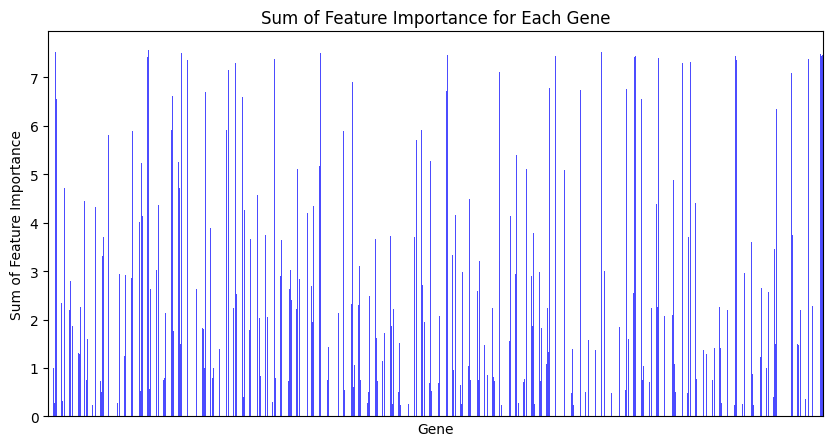

In [ ]:
# Plot a diagram whose x-axis is the df columns and the y-axis is the sum of the df rows
plt.figure(figsize=(10, 5))
df1.sum(axis=0).plot(kind='bar', color='blue', alpha=0.7)
# Hide labels on x-axis
plt.xticks([])
plt.title('Sum of Feature Importance for Each Gene')
plt.xlabel('Gene')
plt.ylabel('Sum of Feature Importance')
plt.show()

In [61]:
node_ids2, explanations2 = get_cluster_explanations(1, limit=10)

In [62]:
df2 = analyze_explanations(node_ids2, explanations2, threshold=0.7, top_k=None)
df2

,LINC02593,HES4,ISG15,ANKRD65,VWA1,AL691432.4,AL513477.2,PRDM16,ARHGEF16,AJAP1,...,MT-ND2,MT-CO1,MT-CO2,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-CYB
2,0.0,0.0,0.715336,0.0,0.000000,0.0,0.0,0.741145,0.0,0.0,...,0.0,0.748441,0.756394,0.736128,0.777467,0.767159,0.0,0.728309,0.729461,0.0
9,0.0,0.0,0.731383,0.0,0.736842,0.0,0.0,0.757030,0.0,0.0,...,0.0,0.735609,0.751499,0.762762,0.750206,0.741409,0.0,0.752514,0.000000,0.0
10,0.0,0.0,0.770536,0.0,0.741580,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.738877,0.744621,0.747597,0.744304,0.776746,0.0,0.731893,0.713138,0.0
16,0.0,0.0,0.728115,0.0,0.732712,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.736134,0.749895,0.752413,0.739453,0.733996,0.0,0.738971,0.743728,0.0
18,0.0,0.0,0.788042,0.0,0.763251,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.758263,0.736566,0.750593,0.752369,0.762774,0.0,0.764464,0.722760,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4025,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4030,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4031,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


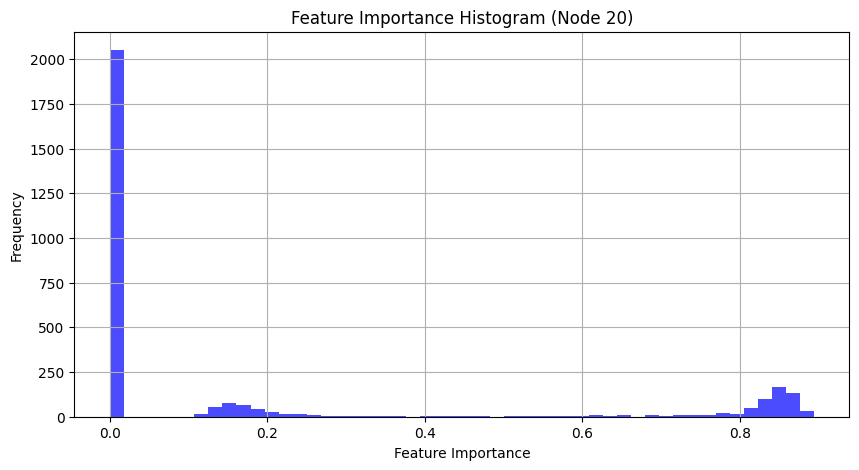

(tensor(14), 'TNFRSF9', tensor(0.8616))
(tensor(16), 'SLC2A5', tensor(0.8279))
(tensor(19), 'FBXO6', tensor(0.8648))
(tensor(23), 'EFHD2', tensor(0.8697))
(tensor(28), 'RCC2', tensor(0.8625))
(tensor(32), 'PLA2G2D', tensor(0.8632))
(tensor(45), 'FUCA1', tensor(0.8871))
(tensor(46), 'CNR2', tensor(0.8523))
(tensor(48), 'RCAN3', tensor(0.8242))
(tensor(63), 'IFI6', tensor(0.8881))
(tensor(71), 'CCDC28B', tensor(0.8555))
(tensor(72), 'LCK', tensor(0.8151))
(tensor(73), 'MARCKSL1', tensor(0.8547))
(tensor(75), 'RBBP4', tensor(0.8519))
(tensor(78), 'RNF19B', tensor(0.8490))
(tensor(94), 'SLC2A1', tensor(0.8410))
(tensor(96), 'CDC20', tensor(0.8437))
(tensor(98), 'KIF2C', tensor(0.8541))
(tensor(102), 'NASP', tensor(0.8264))
(tensor(103), 'MAST2', tensor(0.8138))
(tensor(106), 'STIL', tensor(0.8501))
(tensor(110), 'EPS15', tensor(0.8501))
(tensor(114), 'NDC1', tensor(0.8505))
(tensor(117), 'DHCR24', tensor(0.8466))
(tensor(119), 'USP1', tensor(0.8268))
(tensor(140), 'MTF2', tensor(0.8591))
(

In [83]:
# list the most important features
feature_mask = explanation.node_mask[node_index]


# count non-zero elements in the feature mask
num_nonzero_features = feature_mask.nonzero().size(0)


# Draw a histogram of the feature mask
plt.figure(figsize=(10, 5))
plt.hist(feature_mask.cpu().numpy(), bins=50, color='blue', alpha=0.7)
plt.title(f'Feature Importance Histogram (Node {node_index})')
plt.xlabel('Feature Importance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# important features are above 0.8
important_features_ids = torch.where(feature_mask > 0.8)[0]
important_features_mask = feature_mask[important_features_ids]
important_features = gst.features[node_index][important_features_ids]


hvg = gadata.var[gadata.var['highly_variable']]


# list gene_id from hvg of important features
important_features_gene_ids = hvg.index[important_features_ids].tolist()

print(*zip(important_features_ids, important_features_gene_ids, important_features_mask), sep='\n')



In [ ]:
path = 'feature_importance100.png'

explanation.visualize_feature_importance(path, top_k=100)
print(f"Feature importance plot has been saved to '{path}'")

path = 'subgraph.png'
explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")

Feature importance plot has been saved to 'feature_importance100.png'
Subgraph visualization plot has been saved to 'subgraph.png'
